In [1]:
%matplotlib inline
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
import time

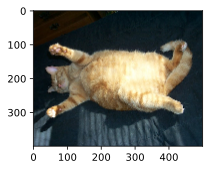

In [2]:
d2l.set_figsize()
img = image.imread('../img/cat1.jpg')
d2l.plt.imshow(img.asnumpy())

In [3]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range (num_cols):
            axes[i][j].imshow(imgs[i * num_cols +j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

In [4]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

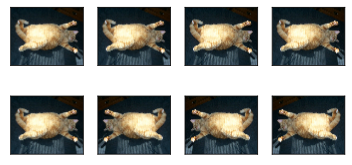

In [5]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

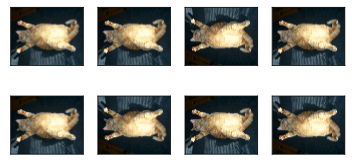

In [6]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())

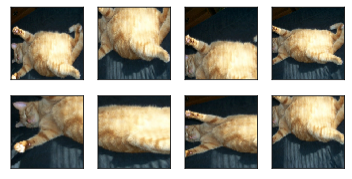

In [7]:
shape_aug = gdata.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

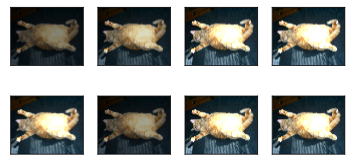

In [8]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

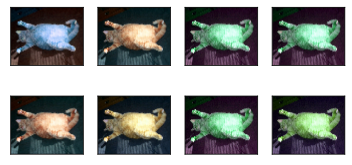

In [9]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

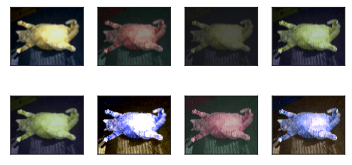

In [10]:
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

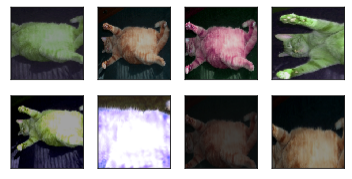

In [11]:
augs = gdata.vision.transforms.Compose([color_aug, shape_aug])
apply(img, augs)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70609ee4e0>,
      dtype=object)

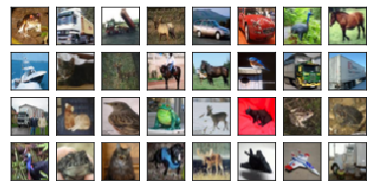

In [12]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8)

In [13]:
flip_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(),
    gdata.vision.transforms.ToTensor()])
no_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()])

In [14]:
num_workers = 0 if sys.platform.startswith('win32') else 4

In [15]:
def load_cifar10(is_train, augs, batch_size):
    return gdata.DataLoader(
        gdata.vision.CIFAR10(train=is_train).transform_first(augs),
    batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [16]:
def _get_batch(batch, ctx):
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
           gutils.split_and_load(labels, ctx), features.shape[0])

In [17]:
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc_sum, n = nd.array([0]), 0
    for batch in data_iter:
        features, labels, _ = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
            n += y.size
        acc_sum.wait_to_read()
    return acc_sum.asscalar()

In [18]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
             % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc, 
               time.time() - start))

In [19]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, ctx, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                           {'learning_rate':lr})
    loss = gloss.SoftmaxCrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=10)

In [20]:
train_with_data_aug(flip_aug, no_aug)

training on [gpu(0)]
epoch 1, loss 1.3612, train acc 0.517, test acc 5766.000, time 35.9 sec
epoch 2, loss 0.8213, train acc 0.708, test acc 6998.000, time 33.9 sec
epoch 3, loss 0.6160, train acc 0.784, test acc 7648.000, time 34.1 sec
epoch 4, loss 0.4988, train acc 0.827, test acc 7843.000, time 34.2 sec
epoch 5, loss 0.3999, train acc 0.862, test acc 7905.000, time 34.2 sec
epoch 6, loss 0.3388, train acc 0.884, test acc 7797.000, time 34.4 sec
epoch 7, loss 0.2855, train acc 0.901, test acc 7845.000, time 34.6 sec
epoch 8, loss 0.2479, train acc 0.914, test acc 8370.000, time 34.7 sec
epoch 9, loss 0.2017, train acc 0.929, test acc 8507.000, time 34.7 sec
epoch 10, loss 0.1773, train acc 0.939, test acc 8277.000, time 34.7 sec
